# 测试任意两卡之间的HCCL通信带宽的脚本

- **平均测试时间**：是指某一算法先做m次预热，再做n次测试，并从n次测试开始计时，计算算法完成时平均每次迭代的耗时

- **算法带宽**：是指申请内存大小/平均时间的数据，包含数据传输、计算和内存复制的带宽



## I. 导入相关的包并定义初始化的变量

In [7]:
import os
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
os.chdir("/root/Workdir/hccl_test")
print(os.getcwd())

/root/Workdir/hccl_test


In [2]:
# 定义npu的总数
npus = 8
# 定义算法的名字和对应的绘图的颜色
test_func = {
    "all_gather" :"black",
    "all_reduce": "red",
    "alltoall": "orange",
    "alltoallv": "green",
    "broadcast": "cyan",
    "reduce": "blue",
    "reduce_scatter": "purple"
}
# 定义要绘制的图形与对应的单位
unit_list = {
    "alg_bandwidth": "GB/s",
    "aveg_time": "s"
}

## II. 进行HCCL测试

### 2.1 清理工作环境

In [9]:
print(os.getcwd())
os.system("make clean")
os.system("rm -rf ./log")
os.system("mkdir ./log")
os.system("mkdir ./log/data")
os.system("mkdir ./log/plot")
os.system("make")

/root/Workdir/hccl_test
rm -rf ./bin/*_test
g++ -std=c++11 -Werror -fstack-protector-strong -fPIE -pie -O2 -s -Wl,-z,relro -Wl,-z,now -Wl,-z,noexecstack -Wl,--copy-dt-needed-entries ./common/src/hccl_check_buf_init.cc ./common/src/hccl_test_main.cc ./common/src/hccl_check_common.cc ./common/src/hccl_opbase_rootinfo_base.cc ./common/src/hccl_test_common.cc ./opbase_test/hccl_allgather_rootinfo_test.cc -I./common/src -I/usr/local/Ascend/ascend-toolkit/latest/include -I/usr/local/Ascend/ascend-toolkit/latest/include -I/root/mpich/include -I./common/utils -I./opbase_test -o all_gather_test -L/usr/local/Ascend/ascend-toolkit/latest/lib64 -lhccl -L/usr/local/Ascend/ascend-toolkit/latest/lib64 -lascendcl -L/root/mpich/lib -lmpi


mkdir: cannot create directory ‘./bin’: File exists


all_gather_test compile completed
g++ -std=c++11 -Werror -fstack-protector-strong -fPIE -pie -O2 -s -Wl,-z,relro -Wl,-z,now -Wl,-z,noexecstack -Wl,--copy-dt-needed-entries ./common/src/hccl_check_buf_init.cc ./common/src/hccl_test_main.cc ./common/src/hccl_check_common.cc ./common/src/hccl_opbase_rootinfo_base.cc ./common/src/hccl_test_common.cc ./opbase_test/hccl_allreduce_rootinfo_test.cc -I./common/src -I/usr/local/Ascend/ascend-toolkit/latest/include -I/usr/local/Ascend/ascend-toolkit/latest/include -I/root/mpich/include -I./common/utils -I./opbase_test -o all_reduce_test -L/usr/local/Ascend/ascend-toolkit/latest/lib64 -lhccl -L/usr/local/Ascend/ascend-toolkit/latest/lib64 -lascendcl -L/root/mpich/lib -lmpi
all_reduce_test compile completed
g++ -std=c++11 -Werror -fstack-protector-strong -fPIE -pie -O2 -s -Wl,-z,relro -Wl,-z,now -Wl,-z,noexecstack -Wl,--copy-dt-needed-entries ./common/src/hccl_check_buf_init.cc ./common/src/hccl_test_main.cc ./common/src/hccl_check_common.cc ./comm

0

### 2.2 获取遍历列表

In [10]:
args = []
for npu0 in range(npus):
    for npu1 in range(npus):
        for func in test_func:
            if npu0 <= npu1: continue
            arg = {
                "npu0": npu0,
                "npu1": npu1, 
                "func": func
            }
            args.append(arg)
print(f'len args: {len(args)}')

len args: 196


### 2.3 执行测试脚本

```text
-b,--minbytes <min size in bytes>
-e,--maxbytes <max size in bytes>
-i,--stepbytes <increment size>
-f,--stepfactor <increment factor>
-n,--iters <iteration count>
-o,--op <sum/prod/min/max>
-d,--datatype <int8/int16/int32/fp16/fp32/int64/uint64/uint8/uint16/uint32/fp64/bfp16>
-r,--root <root>
-w,--warmup_iters <warmup iteration count>
-c,--check <result verification> 0:disabled 1:enabled.
-p,--npus <npus used for one node>
-h,--help
```

In [11]:
for i in trange(len(args)):
    func = args[i]["func"]
    npu0 = args[i]["npu0"]
    npu1 = args[i]["npu1"]
    os.environ['HCCL_TEST_USE_DEVS'] = f'{npu0},{npu1}'
    os.system(f"mpirun -n 2 ./bin/{func}_test -b 10M -e 4096M -f 2 -p 2 > ./log/data/{func}_npu{npu0}-{npu1}.log")

  0%|          | 0/196 [00:00<?, ?it/s]

 43%|████▎     | 84/196 [55:58<1:09:18, 37.13s/it]

## III. 绘图

### 3.1 绘图预处理

In [6]:
src_data = {}
for func in test_func:
    src_data[func] = []
for i in range(len(args)):
    func = args[i]["func"]
    npu0 = args[i]["npu0"]
    npu1 = args[i]["npu1"]
    file_path = f'./log/data/{func}_npu{npu0}-{npu1}.log'
    if not os.path.exists(file_path):
        print(f'skip file: {func}_npu{npu0}-{npu1}.log')
        continue
    with open(file_path, 'r+') as file:
        lines = file.readlines()
    data_size = []
    aveg_time = []
    alg_bandwidth = []
    for line in lines:
        values = line.replace(' ', '').split('|')
        try:
            data_size.append(int(values[0]) / 1024 / 1024)
            aveg_time.append(float(values[1]))
            alg_bandwidth.append(float(values[2]))
        except:
            continue
    src_data[func].append({
        "npu":f"npu{npu0}-npu{npu1}",
        "data_size":data_size,
        "aveg_time":aveg_time,
        "alg_bandwidth":alg_bandwidth,
    })

### 3.2 按照算法分类进行绘图

ValueError: zero-size array to reduction operation maximum which has no identity

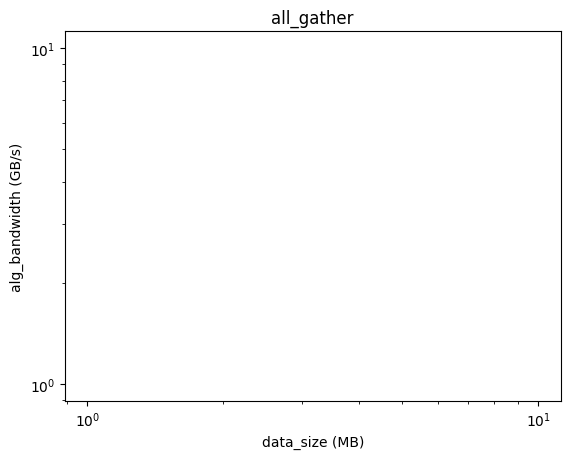

In [7]:
for func in test_func:
    values = src_data[func]
    for title in unit_list:
        unit = unit_list[title]
        plt.cla()
        plt.title(func)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("data_size (MB)")
        plt.ylabel(f"{title} ({unit})")
        for value in values:
            x_data = value["data_size"]
            y_data = value[title]
            if title == 'alg_bandwidth':
                l_data = f'{value["npu"]} (MAX: %.2f {unit})' % np.max(y_data)
            else:
                l_data = value["npu"]
            plt.plot(x_data, y_data, label=l_data)
        if title == 'alg_bandwidth':
            plt.legend(loc="lower right")
        else:
            plt.legend(loc="upper left")
        plt.savefig(f"./log/plot/{title}_{func}.png")

### 3.3 所有数据一起绘图

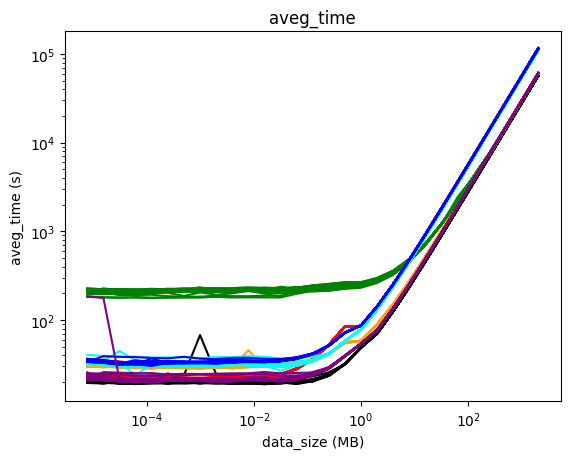

In [ ]:
for title in unit_list:
    unit = unit_list[title]
    y_values = []
    plt.cla()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("data_size (MB)")
    plt.ylabel(f"{title} ({unit})")
    for func in test_func:
        values = src_data[func]
        for value in values:
            x_data = value["data_size"]
            y_data = value[title]
            y_values.extend(y_data)
            plt.plot(x_data, y_data, color=test_func[func])
    if title == 'alg_bandwidth':
        plt.title(f'{title} (MAX: %.2f {unit})' % max(y_values))
    else:
        plt.title(title)
    plt.savefig(f"./log/{title}_{func}.png")